In [1]:
# Exercise 7.2 – Detecting periodicity
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def load_sunspots(path="Files/sunspots.txt"):
    path = Path(path)
    data = np.loadtxt(path, comments="#", delimiter=None, ndmin=2)
    if data.shape[1] < 2:
        raise ValueError("sunspots.txt must have at least two columns.")
    t = data[:, 0].astype(float)   # month index (1, 2, 3, ...)
    y = data[:, 1].astype(float)   # sunspot number
    return t, y

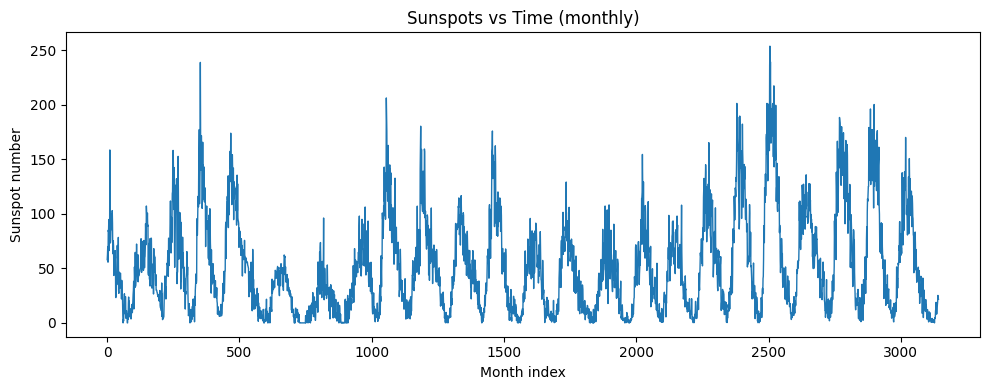

In [3]:
t, y = load_sunspots()

plt.figure(figsize=(10, 4))
plt.plot(t, y, linewidth=1)
plt.xlabel("Month index")
plt.ylabel("Sunspot number")
plt.title("Sunspots vs Time (monthly)")
plt.tight_layout()
plt.show()

Period ≈ 132.7 months  (≈ 11.06 years)


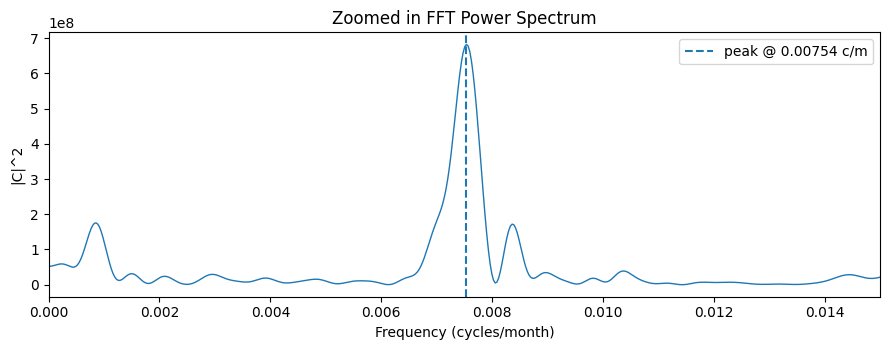

In [4]:
# Detrend + center
tt = t - t.mean()
r  = y - np.polyval(np.polyfit(tt, y, 1), tt)
r -= r.mean()
N = len(r)
w = np.hanning(N)
rw = r * w
nfft = 1 << (int(np.ceil(np.log2(N))) + 3)  # ×8 zero padding

# FFT power
ck    = np.fft.rfft(rw, nfft)
freqs = np.fft.rfftfreq(nfft, d=1.0)   # cycles per month
power = (ck.real**2 + ck.imag**2)

# Band-limit: 8–15 years (96–180 months)
f_lo, f_hi = 1/180, 1/96
band = (freqs >= f_lo) & (freqs <= f_hi)
f_peak = freqs[band][np.argmax(power[band])]
T = 1.0 / f_peak

print(f"Period ≈ {T:.1f} months  (≈ {T/12:.2f} years)")

# Quick spectrum view (optional)
plt.figure(figsize=(9,3.6))
plt.plot(freqs, power, lw=1)
plt.axvline(f_peak, ls="--", label=f"peak @ {f_peak:.5f} c/m")
plt.xlim(0, 0.015)
plt.xlabel("Frequency (cycles/month)"); plt.ylabel("|C|^2")
plt.title("Zoomed in FFT Power Spectrum")
plt.legend(); plt.tight_layout(); plt.show()


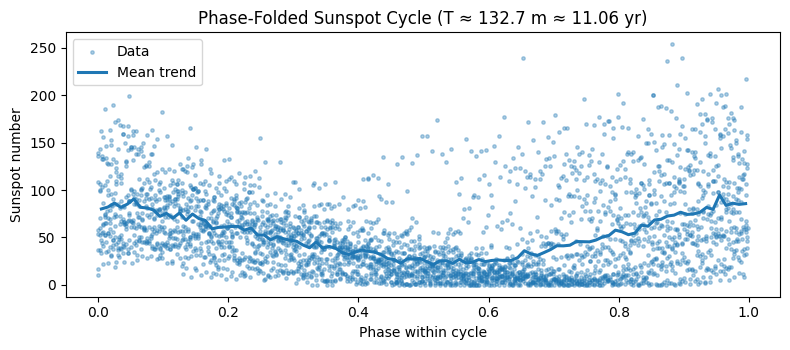

In [5]:
# For fun extra because I turned in this homework super late: phase-fold using T_peak
# Phase fold
phase = (t % T) / T

# Bin average for a clean mean curve (tiny helper in-line)
nbins = 100
bins = np.linspace(0, 1, nbins+1)
idx  = np.digitize(phase, bins) - 1
y_mean = np.array([y[idx==i].mean() if np.any(idx==i) else np.nan for i in range(nbins)])
centers = 0.5*(bins[1:]+bins[:-1])

plt.figure(figsize=(8,3.6))
plt.scatter(phase, y, s=6, alpha=0.35, label="Data")
plt.plot(centers, y_mean, lw=2.2, label="Mean trend")
plt.xlabel("Phase within cycle"); plt.ylabel("Sunspot number")
plt.title(f"Phase-Folded Sunspot Cycle (T ≈ {T:.1f} m ≈ {T/12:.2f} yr)")
plt.legend(); plt.tight_layout(); plt.show()
